# Endogenous grid method

#### Load packages

In [12]:
using Parameters
using Setfield
using Interpolations
using Plots

In this notebook, we want to solve the following household problem: 
\begin{align*}
V(a, y) = \max_{c, a'} &\left\{u(c) + \beta \sum_{y'} \Gamma(y'|y) V(a', y') \right\}
\\
c + a' &= (1 + r_t)a + w y
\\
a' &\geq 0,
\end{align*}

That is, we want to solve for the policy functions $c(a,y)$ and $a'(a,y)$. 

#### Set up structures

In [13]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.95
    γ :: T = 2.0
    ρ :: T = 0.95
    σ2 :: T = 0.02
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 200 # asset grid
    amin :: Float64 = 0.0 
    amax :: Float64 = 50.0 
    ny   :: Int = 5 # income grid
    tol_pol :: Float64 = 1e-7
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)       # transition matrix income
    gridY :: Array{Float64,1} = zeros(n_par.ny)   # income grid
end

Grids

#### Discretization

In [14]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM

Consider the Euler equation arising from the problem above (ignoring the borrowing constraint):

\begin{align*}
u_c(c(a,y)) &= \beta (1 + r) \  \mathbb{E} \quad \quad \quad \quad \ u_c(c(a',y')) \\ 
\Rightarrow u_c(c(a,y)) &= \beta (1 + r) \sum_{y'} \ \Gamma(y'|y) \ u_c(c(a',y')) \notag
\end{align*}

The second line follows because $y$ follows an AR(1) process, which we will discretize using the Rouwenhorst method. $\Gamma$ denotes the transition matrix.  

Now on to today's main event. The endogenous grid method (EGM) which can be used to solve for the optimal policy functions of households. The beauty of the EGM method, compared to a standard policy function iteration, is that one does not need a root-finding step when iterating on the Euler equation. 

- The trick is to make a grid over future(!) assets. Start by guessing the future policy function $\hat{c}(a',y')$. Construct the RHS of the Euler equation for every $(a',y)$ state combination. Call this $F(a',y)$:
\begin{align*}
F(a',y) &\equiv \beta (1 + r) \sum_{y'} \ \Gamma(y'|y) \ u_c(\hat{c}(a',y')). 
\end{align*}

- Then use the Euler equation to solve *analytically* for the value $\tilde{c}(a',y)$:
\begin{align*}
 \tilde{c}(a',y) &= u_c^{-1}(F(a',y)). 
\end{align*}
This is why the EGM is so efficient. It does not require a numerical step at this point. 

- Next, compute the level of assets $a^*(a',y)$ from the budget constraint. 
\begin{align*}
 \tilde{c}(a',y) + a' &= (1+r) a^*  + wy. 
\end{align*}
$a^*(a',y)$ is the value of assets today that would lead the consumer to have $a'$ assets tomorrow if her income shock was $y$ today. The $a^*s$ are the endogenous grid points, whence the name, and change each iteration. Note that $\tilde{c}(a',y) = c(a^*,y).$

If an agent is constrained, she is not on the Euler equation. The consumption can then be backed out from the budget constraint and setting a' = 0.

- Next, update our guess defined on the original grid. To get a new guess $\hat{c}(a',y)$, use linear interpolation. Create the mapping between $a^* \mapsto c(a^*,y)$ and apply it on the grid $\{a'\}$. 

- Check convergence. If successful, stop, if not use the new guess and repeat. 


Below, I write down two different EGMs. One that iterates over assets (egm_assets) and one that iterates over consumption (egm) as described above.

In [15]:
function egm_assets(r,rprime,w, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, gV_conHA::ContainerHA)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    @unpack_ContainerHA gV_conHA

    Ai= copy(A)
    difference= 1000.0
    it=0
    Uc= zeros(na,ny)

    while difference > tol_pol && it < 1000

        for y in 1:ny
            Uc[:,y]= ( (1+r)*gridA .+ w*gridY[y] .- A[:,y] ).^(-γ)
        end
        EUc= Uc * Π' # expectation (* is matrix multiplication)
        RHS= β * (1+rprime) .* EUc # RHS of Euler
        for y in 1:ny
            Cendog= RHS[:,y].^(-1/γ)
            Aendog= (gridA .+ Cendog .- w*gridY[y]) ./ (1 + r)
            itp= LinearInterpolation(Aendog, gridA, extrapolation_bc=Line())
            Ai[:,y]= itp.(gridA)
        end        
        Ai[Ai.<=amin] .= amin # set borrowing constraint
        difference= maximum(abs.(A .- Ai))
        A= copy(Ai)

        it= it+1

    end 

    # Asset policy function
    for y in 1:ny
        C[:,y]= (1+r).*gridA .+ w*gridY[y] .- A[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C)

    println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end


function egm(r,rprime,w, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, gV_conHA::ContainerHA)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    @unpack_ContainerHA gV_conHA


    
    difference= 1000.0
    it=0
    na_c = na ÷ 2


    # fill consumption policy with guess
    C= ones(n_par.na, n_par.ny) .* r .+ gridA;
    # pre-allocation 
    Ci= similar(C, Float64)
    
    # minimum consumption: solve for consumption via budget constraint, when assets are at lower bound
    Cl= r * n_par.amin .+ w .* gridY

    while difference > tol_pol && it < 1000


        EUc= C.^(-γ) * Π'  # RHS Euler (expectation)
        RHS= β * (1+rprime) .* EUc # RHS of Euler
        for y in 1:ny

            # unconstrained
            Cendog= RHS[:,y].^(-1/γ)
            Aendog= (gridA .+ Cendog .- w*gridY[y]) ./ (1 + r)
            itp= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
            Ci[:,y]= itp.(gridA)

            # constrained
            if Aendog[1] > amin            
                Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
                Aendog_c= (amin .+ Cendog_c .- w.*gridY[y]) ./ (1 + r)

                Cendog= append!(Cendog_c, Cendog)
                Aendog= append!(Aendog_c, Aendog)
            end

            itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
            Ci[:,y]= itpC.(gridA)

        end        

        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)


        it= it+1

    end 

    # Consumption policy function
    for y in 1:n_par.ny
        A[:,y]= w .* grids.gridY[y] .+ (1+r).*grids.gridA .- C[:,y]
    end


    gV_conHA= ContainerHA(A=A, C=C)

    println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

#### Initialize

In [16]:
m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();

lnincomeGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
incomeGrid= exp.(lnincomeGrid)

gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
grids= Grids(gridA=gridA, Π=transitionMatrix, gridY=incomeGrid);

#### Illustration

In [17]:
## Household takes prices as given
# Interest rate
r= 0.03
# Wage
w= 1.0


# Create guess
Cguess= ones(n_par.na, n_par.ny) .* r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);

# EGM
gV_conHA_assets= egm_assets(r, r, w, m_par, n_par, grids, gV_conHA); # in steady state, r=rprime 
gV_conHA= egm(r, r, w, m_par, n_par, grids, gV_conHA); # in steady state, r=rprime 


Finished EGM in iteration = 43, and diff = 5.4189086995393154e-8
Finished EGM in iteration = 54, and diff = 5.539692793377071e-8


In [7]:
# Comparison
println(maximum(abs.((gV_conHA.C .- gV_conHA_assets.C))))
println(maximum(abs.((gV_conHA.A .- gV_conHA_assets.A))))

3.938113080081962e-8
3.938112769219515e-8


#### Plot policy functions

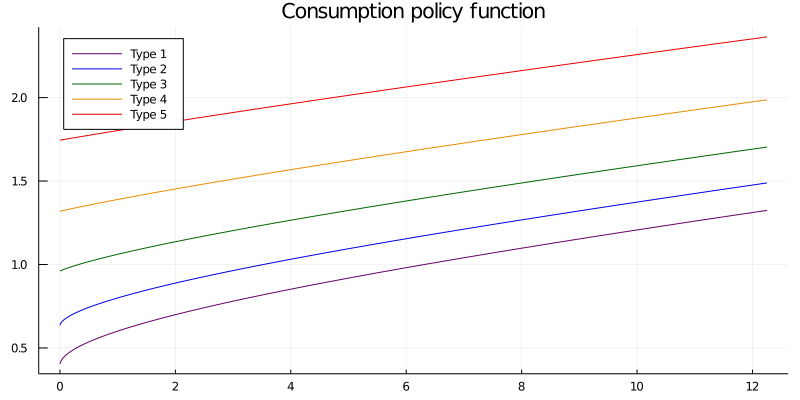

In [8]:
plot(grids.gridA[1:100], gV_conHA.C[1:100,:], legend=:topleft, title="Consumption policy function", label=["Type 1" "Type 2" "Type 3" "Type 4" "Type 5"], palette =:darkrainbow)
plot!(size=(800,400))

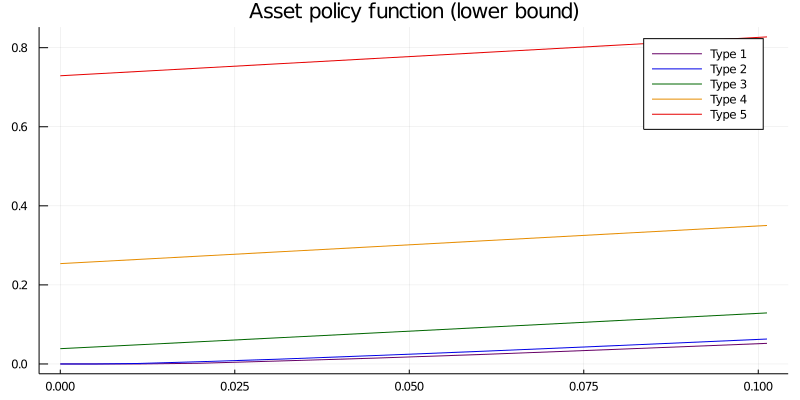

In [9]:
plot(grids.gridA[1:10], gV_conHA.A[1:10,:], legend=:topright, title="Asset policy function (lower bound)", label=["Type 1" "Type 2" "Type 3" "Type 4" "Type 5"], palette =:darkrainbow)
plot!(size=(800,400))

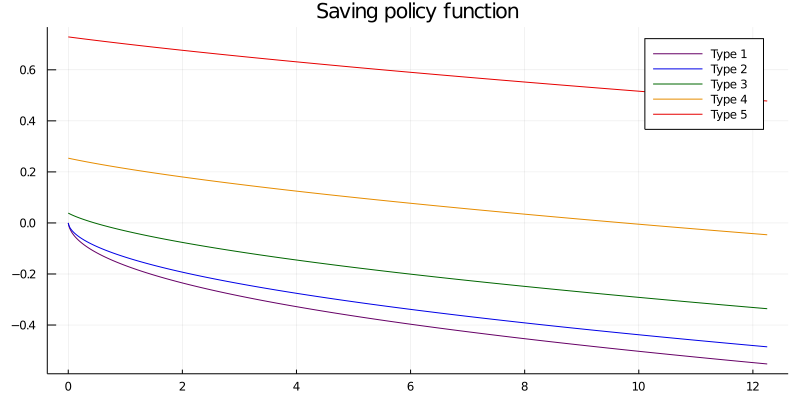

In [10]:
plot(grids.gridA[1:100], gV_conHA.A[1:100,:] .- grids.gridA[1:100], legend=:topright, title="Saving policy function", label=["Type 1" "Type 2" "Type 3" "Type 4" "Type 5"], palette =:darkrainbow)
plot!(size=(800,400))